In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Download and Data preprocessing

In [3]:
!curl -LJ "https://raw.githubusercontent.com/ningshixian/NER-CONLL2003/master/data/train.txt" -o "train.txt"
!curl -LJ "https://raw.githubusercontent.com/ningshixian/NER-CONLL2003/master/data/valid.txt" -o "valid.txt"
!curl -LJ "https://raw.githubusercontent.com/ningshixian/NER-CONLL2003/master/data/test.txt" -o "test.txt"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3206k  100 3206k    0     0  8857k      0 --:--:-- --:--:-- --:--:-- 8833k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  808k  100  808k    0     0   717k      0  0:00:01  0:00:01 --:--:--  717k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  730k  100  730k    0     0  2820k      0 --:--:-- --:--:-- --:--:-- 2820k


We'll use fastText for word embedding.

In [4]:
# URL = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip"
# FILE = "fastText"

# if os.path.isdir(FILE):
#     print("fastText exists.")
# else:
#     !wget -P $FILE $URL
#     !unzip $FILE/crawl-300d-2M.vec.zip -d $FILE
fasttext_path = "/gdrive/MyDrive/Colab Notebooks/ConLL-NER/bin/crawl-300d-2M.vec"

In [5]:
!head -5 train.txt

-DOCSTART- -X- -X- O

EU NNP B-NP B-ORG
rejects VBZ B-VP O
German JJ B-NP B-MISC


In [6]:
import nltk
from nltk.corpus.reader import ConllCorpusReader

In [7]:
train_sentences = ConllCorpusReader("./", "train.txt", ["words", "pos", "ignore", "chunk"]).iob_sents()
valid_sentences = ConllCorpusReader("./", "valid.txt", ["words", "pos", "ignore", "chunk"]).iob_sents()
test_sentences = ConllCorpusReader("./", "test.txt", ["words", "pos", "ignore", "chunk"]).iob_sents()

Remove empty (len = 0) sentences due to data error.

In [8]:
train_sentences = [s for s in train_sentences if len(s) > 0]
valid_sentences = [s for s in valid_sentences if len(s) > 0]
test_sentences = [s for s in test_sentences if len(s) > 0]

In [9]:
print(f"Length of train set: {len(train_sentences)}")
print(f"Length of validation set: {len(valid_sentences)}")
print(f"Length of test set: {len(test_sentences)}")

Length of train set: 14041
Length of validation set: 3250
Length of test set: 3453


In [10]:
train_sentences[0]

[('EU', 'NNP', 'B-ORG'),
 ('rejects', 'VBZ', 'O'),
 ('German', 'JJ', 'B-MISC'),
 ('call', 'NN', 'O'),
 ('to', 'TO', 'O'),
 ('boycott', 'VB', 'O'),
 ('British', 'JJ', 'B-MISC'),
 ('lamb', 'NN', 'O'),
 ('.', '.', 'O')]

In [11]:
valid_sentences[0]

[('CRICKET', 'NNP', 'O'),
 ('-', ':', 'O'),
 ('LEICESTERSHIRE', 'NNP', 'B-ORG'),
 ('TAKE', 'NNP', 'O'),
 ('OVER', 'IN', 'O'),
 ('AT', 'NNP', 'O'),
 ('TOP', 'NNP', 'O'),
 ('AFTER', 'NNP', 'O'),
 ('INNINGS', 'NNP', 'O'),
 ('VICTORY', 'NN', 'O'),
 ('.', '.', 'O')]

In [12]:
test_sentences[0]

[('SOCCER', 'NN', 'O'),
 ('-', ':', 'O'),
 ('JAPAN', 'NNP', 'B-LOC'),
 ('GET', 'VB', 'O'),
 ('LUCKY', 'NNP', 'O'),
 ('WIN', 'NNP', 'O'),
 (',', ',', 'O'),
 ('CHINA', 'NNP', 'B-PER'),
 ('IN', 'IN', 'O'),
 ('SURPRISE', 'DT', 'O'),
 ('DEFEAT', 'NN', 'O'),
 ('.', '.', 'O')]

Format the data to (token, chunk)

In [13]:
def create_data(dataset):
    data = []
    label = []
    for sentence in dataset:
        current_data = []
        current_label = []
        
        for token, _, chunk in sentence:
            current_data.append(token.lower())
            current_label.append(chunk)
        
        data.append(current_data)
        label.append(current_label)

    return data, label

In [14]:
train_data, train_labels = create_data(train_sentences)
val_data, val_labels = create_data(valid_sentences)
test_data, test_labels = create_data(test_sentences)

In [15]:
train_data[0], train_labels[0]

(['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.'],
 ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O'])

In [16]:
val_data[0], val_labels[0]

(['cricket',
  '-',
  'leicestershire',
  'take',
  'over',
  'at',
  'top',
  'after',
  'innings',
  'victory',
  '.'],
 ['O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])

In [17]:
test_data[0], test_labels[0]

(['soccer',
  '-',
  'japan',
  'get',
  'lucky',
  'win',
  ',',
  'china',
  'in',
  'surprise',
  'defeat',
  '.'],
 ['O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O'])

## Create dataset

In [18]:
import torch
from torch.utils.data import Dataset, DataLoader

In [19]:
class ConLLDataset(Dataset):
    def __init__(self, sentences, labels):
        super().__init__()
        
        self.sentences = sentences
        self.labels = labels
    
        self.length = len(self.sentences)
    
    def __getitem__(self, idx):
        return self.sentences[idx], self.labels[idx]
    
    def __len__(self):
        return self.length

In [20]:
train_dataset = ConLLDataset(train_data, train_labels)
val_dataset = ConLLDataset(val_data, val_labels)

In [21]:
next(iter(train_dataset))

(['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.'],
 ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O'])

In [22]:
next(iter(val_dataset))

(['cricket',
  '-',
  'leicestershire',
  'take',
  'over',
  'at',
  'top',
  'after',
  'innings',
  'victory',
  '.'],
 ['O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])

Build vocabulary from given dataset (training only!)

In [23]:
from torchtext.vocab import build_vocab_from_iterator

In [24]:
def yield_tokens(data_iter):
    for sentence, label in data_iter:
        yield sentence

In [25]:
vocabulary = build_vocab_from_iterator(yield_tokens(iter(train_dataset)), specials = ["<pad>", "<unk>"])
vocabulary.set_default_index(vocabulary["<pad>"])

In [26]:
vocabulary["<pad>"], vocabulary["<unk>"]

(0, 1)

In [27]:
len(vocabulary)

21011

In [28]:
vocabulary(next(iter(train_dataset))[0])

[1004, 18979, 205, 637, 7, 4083, 216, 6755, 3]

In [29]:
vocabulary(next(iter(val_dataset))[0])

[293, 18, 2535, 265, 73, 19, 392, 42, 286, 312, 3]

## Labels encoding

In [30]:
unique_labels = list({x for l in train_labels for x in l})

In [31]:
unique_labels

['B-LOC', 'I-LOC', 'B-MISC', 'I-PER', 'I-MISC', 'I-ORG', 'O', 'B-ORG', 'B-PER']

In [32]:
label2idx = {label : idx for idx, label in enumerate(unique_labels)}
idx2label = {idx : label for idx, label in enumerate(unique_labels)}

In [33]:
label2idx["B-ORG"], idx2label[1]

(7, 'I-LOC')

Using Seq2Seq requires similar length in both input and output. Hence we'll need a small analysis on the data length to determine the max length.

In [34]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


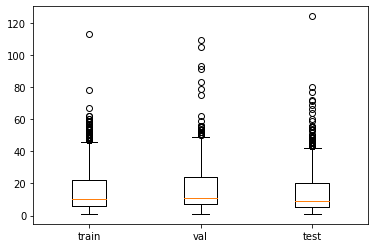

In [35]:
d = {"train" : [len(s) for s in train_data], "val" : [len(s) for s in val_data], "test" : [len(s) for s in test_data]}

fig, ax = plt.subplots()

ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
plt.show()

Except some sentences are 100-120 tokens length, we can use 64 tokens for a sentence.

In [36]:
MAX_SEQ_LENGTH = 64

In [121]:
def pad_sequence(sequence):
    padded_sequences = np.zeros((len(sequence),), dtype = float)
    
    current_len = len(sequence)

    if current_len <= MAX_SEQ_LENGTH:
        zeroes = list(np.zeros(MAX_SEQ_LENGTH - current_len))
        new = sequence + zeroes

    elif current_len > MAX_SEQ_LENGTH:
        new = sequence[0:MAX_SEQ_LENGTH]
        
    return new

In [122]:
vectorized_sample = vocabulary(next(iter(train_dataset))[0])
pad_sequence(vectorized_sample)

[1004,
 18979,
 205,
 637,
 7,
 4083,
 216,
 6755,
 3,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [123]:
from tqdm import tqdm_notebook

In [124]:
def load_pretrained_vectors(word2idx, fname):
    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['<pad>']] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for line in tqdm_notebook(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype='float')

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

In [147]:
# Load embedding
embeddings = load_pretrained_vectors(vocabulary, fasttext_path)
embeddings = torch.tensor(embeddings, dtype=torch.float)

Loading pretrained vectors...


<ipython-input-124-7193fb73b598>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(fin):


0it [00:00, ?it/s]

There are 16937 / 21011 pretrained vectors found.


In [150]:
embeddings

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2391,  0.0080,  0.2112,  ..., -0.1464, -0.1186, -0.1972],
        [ 0.0231,  0.0170,  0.0157,  ...,  0.0744, -0.1118,  0.0963],
        ...,
        [-0.1581, -0.0706, -0.0151,  ..., -0.1966,  0.2045, -0.1789],
        [ 0.3446, -0.4639,  0.6707,  ...,  0.2111, -0.0163,  0.1816],
        [-0.0407,  0.1726,  0.5130,  ...,  0.5594, -0.1172, -0.1871]])

Create a dataloader

In [148]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [149]:
def collate_batch(batch):
    sentences, labels = [], []
    
    for (sentence, label) in batch:
        sentence_tensor = torch.tensor(vocabulary(sentence), dtype = torch.long)
        sentences.append(sentence_tensor)
        
        label = torch.tensor([label2idx[l] for l in label], dtype = torch.long)
        labels.append(label)
    
    
    sentences = torch.cat(sentences)
    labels = torch.cat(labels)
    
    
    return sentences.to(device), labels.to(device)

# Model

In [152]:
class ConLLPOSTagging_RNN(torch.nn.Module):
    def __init__(self, pretrained_embedding=None, freeze_embedding=True, hidden_size=64, output_dim=64, num_layers=4):
        super().__init__()
        
        self.output_dim = output_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.vocab_size, self.embedding_dim = pretrained_embedding.shape

        self.embedding = torch.nn.Embedding.from_pretrained(
            embeddings=pretrained_embedding,
            freeze=freeze_embedding
        )

        self.gru = torch.nn.GRU(
            input_size = self.embedding_dim,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            bidirectional = True
        )
        
        self.fc = torch.nn.Linear(
            in_features = self.hidden_size * 2,
            out_features = self.output_dim
        )
    
    def forward(self, sentence):
        embedded = self.embedding(sentence)
        
        rnn_output, _ = self.gru(embedded.view(len(sentence), 1, -1))
        tag_space = self.fc(rnn_output.view(len(sentence), -1))
        tag_scores = torch.nn.functional.log_softmax(tag_space, dim = 1)

        return tag_scores
        

Hyperparameters

In [153]:
batch_size = 64
epochs = 100
learning_rate = .001

freeze_embedding=True
hidden_size = 64
num_layers = 4
output_dim = len(unique_labels)

In [154]:
model = ConLLPOSTagging_RNN(
    pretrained_embedding=embeddings,
    freeze_embedding=freeze_embedding,
    hidden_size = hidden_size,
    output_dim = output_dim,
    num_layers = num_layers
).to(device)

In [155]:
# Loss function
loss_fn = torch.nn.NLLLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [156]:
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn = collate_batch)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True, collate_fn = collate_batch)

# Training

In [158]:
with torch.no_grad():
    inputs = next(iter(train_dataloader))
    tag_scores = model(inputs[0])
    print(tag_scores)

tensor([[-2.1486, -2.1902, -2.1198,  ..., -2.3071, -2.2539, -2.2313],
        [-2.1548, -2.2088, -2.1073,  ..., -2.3077, -2.2757, -2.2090],
        [-2.1696, -2.2239, -2.1077,  ..., -2.2991, -2.2872, -2.1917],
        ...,
        [-2.2398, -2.2397, -2.1433,  ..., -2.2933, -2.2189, -2.2224],
        [-2.2144, -2.2312, -2.1551,  ..., -2.3000, -2.2023, -2.2282],
        [-2.1900, -2.2195, -2.1758,  ..., -2.3069, -2.1936, -2.2245]],
       device='cuda:0')


In [159]:
import time

In [160]:
def train(loader, verbose = False):
    model.train()
    
    total_accuracy, total_count = 0, 0
    log_interval = 20

    start_time = time.time()
    
    for idx, (sentence, label) in enumerate(loader):
        optimizer.zero_grad()

        tag_scores = model(sentence)

        # Loss and backpropagation
        loss = loss_fn(tag_scores, label)
        loss.backward()
        optimizer.step()
        
        # Accuracy
        total_accuracy += (tag_scores.argmax(axis =1) == label).sum().item()
        total_count += label.size(0)
        
        if idx % log_interval == 0 and idx > 0:
            elapsed_time = time.time() - start_time
    
            accuracy = total_accuracy / total_count
            
            if verbose:
                print(f"Epoch {epoch + 1} / {epochs} | Batch: {idx} / {len(loader)} | Training loss: {loss} | Accuracy: {accuracy}")
            
            total_accuracy, total_count = 0, 0
            
            start_time = time.time()

In [161]:
def evaluate(loader):
    model.eval()
    
    total_loss, total_acc, total_count = 0, 0, 0
    
    with torch.no_grad():
        for idx, (sent, label) in enumerate(loader):
            tag_scores = model(sent)
            
            loss = loss_fn(tag_scores, label)
            
            total_loss += loss
            total_acc += (tag_scores.argmax(axis = 1) == label).sum().item()
            total_count += label.size(0)
    
    val_loss, val_acc = total_loss / total_count, total_acc / total_count
    
    return val_loss, val_acc

In [162]:
# EarlyStopping
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [163]:
patience = 10
verbose = True

early_stopping = EarlyStopping(patience = patience, verbose = verbose)

In [164]:
current_acc = 0.0
loss, acc = [], []

for epoch in tqdm_notebook(range(epochs)):
    epoch_start_time = time.time()
    
    train(train_dataloader)
    
    val_loss, val_acc = evaluate(val_dataloader)
    
    loss.append(val_loss)
    acc.append(val_acc)
    
    print("-" * 50)
    print(f"End of epoch {epoch + 1} | time: {time.time() - epoch_start_time} | val_loss: {val_loss:.6f} | val_acc: {val_acc:.6f}")
    print("-" * 50)

    early_stopping(val_loss, model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break

<ipython-input-164-666b1daa6c84>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs)):


  0%|          | 0/100 [00:00<?, ?it/s]

--------------------------------------------------
End of epoch 1 | time: 4.839831829071045 | val_loss: 0.000233 | val_acc: 0.930357
--------------------------------------------------
Validation loss decreased (inf --> 0.000233).  Saving model ...
--------------------------------------------------
End of epoch 2 | time: 4.0802271366119385 | val_loss: 0.000186 | val_acc: 0.943616
--------------------------------------------------
Validation loss decreased (0.000233 --> 0.000186).  Saving model ...
--------------------------------------------------
End of epoch 3 | time: 4.006951093673706 | val_loss: 0.000181 | val_acc: 0.940228
--------------------------------------------------
Validation loss decreased (0.000186 --> 0.000181).  Saving model ...
--------------------------------------------------
End of epoch 4 | time: 4.006250381469727 | val_loss: 0.000168 | val_acc: 0.943888
--------------------------------------------------
Validation loss decreased (0.000181 --> 0.000168).  Saving mo

In [165]:
import matplotlib.pyplot as plt

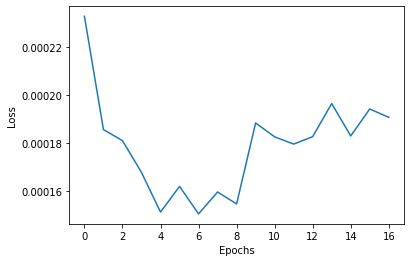

In [166]:
plt.plot([l.cpu() for l in loss])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

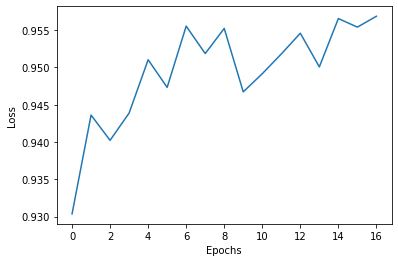

In [167]:
plt.plot(acc)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Prediction

In [169]:
best_checkpoint = ConLLPOSTagging_RNN(
    pretrained_embedding=embeddings,
    freeze_embedding=freeze_embedding,
    hidden_size = hidden_size,
    output_dim = output_dim,
    num_layers = num_layers
).to(device)

In [170]:
best_checkpoint.load_state_dict(torch.load("checkpoint.pt"))

<All keys matched successfully>

In [171]:
def predict(text):
    with torch.no_grad():
        text = torch.tensor(vocabulary(text)).to(device)
        output = best_checkpoint(text).to(device)
    
    
    return [x.item() for x in output.argmax(axis = 1)]

In [172]:
predicted = []
for text in test_data:
    predicted.append(predict(text))

A bizarre move: I'll fattern all sentences by appending all of them into 1 predicted and label vector.

In [173]:
y_pred, y_test = [], []

for s in predicted:
    for l in s:
        y_pred.append(l)

for s in test_labels:
    for l in s:
        y_test.append(label2idx[l])

In [174]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [175]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.6f} | Precision: {precision_score(y_test, y_pred, average = 'weighted'):.6f} | Recall: {recall_score(y_test, y_pred, average = 'weighted'):.6f} | F1 score: {f1_score(y_test, y_pred, average = 'weighted'):.6f}")

Accuracy: 0.940627 | Precision: 0.944152 | Recall: 0.940627 | F1 score: 0.941875


In [176]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1668
           1       0.73      0.64      0.68       257
           2       0.76      0.67      0.71       702
           3       0.90      0.91      0.91      1156
           4       0.58      0.59      0.59       216
           5       0.71      0.71      0.71       835
           6       0.98      0.97      0.98     38323
           7       0.60      0.78      0.68      1661
           8       0.81      0.86      0.83      1617

    accuracy                           0.94     46435
   macro avg       0.77      0.77      0.77     46435
weighted avg       0.94      0.94      0.94     46435



In [177]:
print(confusion_matrix(y_test, y_pred))

[[ 1399     4    40     1     1     2    76   127    18]
 [   26   165     0     5    12    19    29     0     1]
 [   20     1   472     1     8     3   111    72    14]
 [    0     2     0  1055     0    25    65     2     7]
 [    0     2     9     3   127    10    61     2     2]
 [    9    20     2    19    10   590   132    52     1]
 [   49    33    77    64    59   150 37183   485   223]
 [   70     0    23     3     1    25   183  1293    63]
 [   11     0     1    17     0     3    86   105  1394]]


In [178]:
import seaborn as sns

In [179]:
for i in range(10):
    sample_predict = predict(test_data[i])
    for text, label_true, label_pred in zip(test_data[i], test_labels[i], sample_predict):
        print(text, label_true, idx2label[label_pred])
    
    print("-" * 50)

soccer O O
- O O
japan B-LOC B-LOC
get O O
lucky O O
win O O
, O O
china B-PER B-LOC
in O O
surprise O O
defeat O O
. O O
--------------------------------------------------
nadim B-PER O
ladki I-PER O
--------------------------------------------------
al-ain B-LOC B-LOC
, O O
united B-LOC B-LOC
arab I-LOC B-LOC
emirates I-LOC I-LOC
1996-12-06 O O
--------------------------------------------------
japan B-LOC B-LOC
began O O
the O O
defence O O
of O O
their O O
asian B-MISC B-MISC
cup I-MISC I-MISC
title O O
with O O
a O O
lucky O O
2-1 O O
win O O
against O O
syria B-LOC B-LOC
in O O
a O O
group O O
c O O
championship O O
match O O
on O O
friday O O
. O O
--------------------------------------------------
but O O
china B-LOC B-LOC
saw O O
their O O
luck O O
desert O O
them O O
in O O
the O O
second O O
match O O
of O O
the O O
group O O
, O O
crashing O O
to O O
a O O
surprise O O
2-0 O O
defeat O O
to O O
newcomers O O
uzbekistan B-LOC O
. O O
-----------------------------------------